In [43]:
library(ggplot2)
library(data.table)
library("vegan")
library(patchwork)
library("ggpubr")
library(smacof)
setwd('/data6/Angelo/alexcc/AngeloStrainsPaper/manuscript_materials/soil_popgen/notebooks')

In [3]:
genomes = c("14_0903_05_40cm_Acidobacteria_477_57_13",
            "14_1009_16_30cm_Bacteria_10556_58_16",
            "14_0929_09_30cm_Armatimonadetes_6837_65_8",
            "14_0927_05_20cm_Bacteria_2135_68_10",
            "14_0929_02_20cm_Deltaproteobacteria_2457_55_9",
            "14_0929_09_20cm_Bacteria_6721_56_10",
            "14_0929_12_30cm_Bacteria_7383_54_8",
            "14_1009_05_40cm_Bacteria_4402_54_13",
            "14_0927_12_40cm_Bacteria_6527_55_8",
            "14_1009_02_30cm_Bacteria_3696_55_11",
            "14_0903_09_40cm_Bacteria_750_66_8",
            "14_1009_05_40cm_Gemmatimonadetes_4339_69_30",
            "14_1009_02_30cm_Gemmatimonadetes_3684_69_12",
            "14_1009_02_40cm_Gemmatimonadetes_3800_70_27",
            "14_0927_05_20cm_Gemmatimonadetes_2150_69_20",
            "14_1009_02_40cm_Gemmatimonadetes_3801_70_15",
            "14_0929_02_40cm_Rokubacteria_2807_70_29",
            "14_0903_02_20cm_Proteobacteria_56_68_14",
            "14_0903_12_20cm_Proteobacteria_884_68_14")

In [21]:
d = read.csv('../data_tables/Cdb2.csv')
n = read.csv("../data_tables/Ndb.csv")

d$genome = sub(pattern = ".fasta", replacement = "", x=d$genome)
n$query = n$querry
n$querry = NULL
n$query = sub(pattern = ".fasta", replacement = "", x=n$query)
n$reference = sub(pattern = ".fasta", replacement = "", x=n$reference)

In [23]:
head(d)

genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster,sample,Treat_Control,Time_Point,Plot,Depth
<chr>,<fct>,<dbl>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>
14_0927_12_40cm_Thaumarchaeota_6519_36_7,1_1,0.03,average,ANImf,1,14_0927_12_40cm,control,2,12,40
14_1009_12_40cm_Thaumarchaeota_8761_35_9,1_1,0.03,average,ANImf,1,14_1009_12_40cm,control,4,12,40
14_1009_12_30cm_Thaumarchaeota_8534_36_6,1_2,0.03,average,ANImf,1,14_1009_12_30cm,control,4,12,30
14_0903_05_40cm_Thaumarchaeota_481_37_7,2_1,0.03,average,ANImf,2,14_0903_05_40cm,control,0,5,40
14_0903_16_40cm_Thaumarchaeota_5674_38_9,2_1,0.03,average,ANImf,2,14_0903_16_40cm,control,0,16,40
14_0929_02_40cm_Thaumarchaeota_2825_38_5,2_1,0.03,average,ANImf,2,14_0929_02_40cm,treatment,3,2,40


In [24]:
head(n)

reference,alignment_length,similarity_errors,ref_coverage,querry_coverage,ani,reference_length,querry_length,alignment_coverage,primary_cluster,query
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>
14_0927_12_40cm_Thaumarchaeota_6519_36_7,1357937,0,0.9995061,0.9995061,1.0000000,1358608,1358608,0.9995061,1,14_0927_12_40cm_Thaumarchaeota_6519_36_7
14_1009_12_30cm_Thaumarchaeota_8534_36_6,935845,64054,0.7871116,0.6888264,0.9315549,1188961,1358608,0.7871116,1,14_0927_12_40cm_Thaumarchaeota_6519_36_7
14_1009_12_40cm_Thaumarchaeota_8761_35_9,1203260,18340,0.8057098,0.8856565,0.9847581,1493416,1358608,0.8856565,1,14_0927_12_40cm_Thaumarchaeota_6519_36_7
14_0927_12_40cm_Thaumarchaeota_6519_36_7,933465,63958,0.6870745,0.7851099,0.9314832,1358608,1188961,0.7851099,1,14_1009_12_30cm_Thaumarchaeota_8534_36_6
14_1009_12_30cm_Thaumarchaeota_8534_36_6,1187164,0,0.9984886,0.9984886,1.0000000,1188961,1188961,0.9984886,1,14_1009_12_30cm_Thaumarchaeota_8534_36_6
14_1009_12_40cm_Thaumarchaeota_8761_35_9,947870,61220,0.6346992,0.7972255,0.9354131,1493416,1188961,0.7972255,1,14_1009_12_30cm_Thaumarchaeota_8534_36_6


In [26]:
# Do PERMANOVA tests on genetic distance matrix for each secondary cluster

results <- data.frame('genome' = character(), 'p_plot' = numeric(), 'r_plot' = numeric(), 'p_depth' = numeric(), 
                      'r_depth' = numeric(), 
                      stringsAsFactors = FALSE)

for (genome in 1:length(genomes)){
    clust = d[which(d$genome == genomes[genome]),]
    cluster2 = d[which(d$secondary_cluster == clust$secondary_cluster[1]),]$genome
    ani_data = n[which(n$reference %in% cluster2 & n$query %in% cluster2),]
    ani_matrix = dcast(ani_data, reference ~ query, value.var = "ani")
    rownames(ani_matrix) = ani_matrix$reference
    ani_matrix$reference = NULL
    dist_mat = as.dist(1-ani_matrix)
    metadata = d[which(d$genome %in% names(ani_matrix)),]
    res = adonis(dist_mat~metadata$Plot+metadata$Depth, permutations=9999)
    results[nrow(results) + 1,] = list(genomes[genome], res$aov.tab[1,'Pr(>F)'],res$aov.tab[1,'R2'],res$aov.tab[2,'Pr(>F)'],res$aov.tab[2,'R2'])
    
}

In [19]:
metadata

,genome,secondary_cluster,threshold,cluster_method,comparison_algorithm,primary_cluster
,<chr>,<fct>,<dbl>,<fct>,<fct>,<int>
436,14_0903_02_30cm_Acidobacteria_170_57_8,75_1,0.03,average,ANImf,75
437,14_0903_02_40cm_Bacteria_2_57_5,75_1,0.03,average,ANImf,75
438,14_0903_05_30cm_Bacteria_4594_57_8,75_1,0.03,average,ANImf,75
439,14_0903_05_40cm_Acidobacteria_477_57_13,75_1,0.03,average,ANImf,75
440,14_0903_09_40cm_Bacteria_747_57_10,75_1,0.03,average,ANImf,75
441,14_0903_13_20cm_Acidobacteria_10553_57_8,75_1,0.03,average,ANImf,75
442,14_0903_13_30cm_Acidobacteria_4936_57_42,75_1,0.03,average,ANImf,75
443,14_0903_13_40cm_Bacteria_1338_57_12,75_1,0.03,average,ANImf,75
444,14_0903_16_30cm_Acidobacteria_5523_57_10,75_1,0.03,average,ANImf,75


In [29]:
## Significant by plot
results[which(p.adjust(results$p_plot, method = 'BH') < 0.05),]


,genome,p_plot,r_plot,p_depth,r_depth
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2,14_1009_16_30cm_Bacteria_10556_58_16,0.0039,0.06880324,0.3060,0.03528102
3,14_0929_09_30cm_Armatimonadetes_6837_65_8,0.0003,0.05840176,0.0675,0.04287353
5,14_0929_02_20cm_Deltaproteobacteria_2457_55_9,0.0001,0.31492937,0.0970,0.03513189
6,14_0929_09_20cm_Bacteria_6721_56_10,0.0251,0.06907257,0.0049,0.08677054
7,14_0929_12_30cm_Bacteria_7383_54_8,0.0105,0.06195681,0.0475,0.05191470
9,14_0927_12_40cm_Bacteria_6527_55_8,0.0002,0.16439547,0.0275,0.08878533
10,14_1009_02_30cm_Bacteria_3696_55_11,0.0003,0.11555988,0.1236,0.05619548
12,14_1009_05_40cm_Gemmatimonadetes_4339_69_30,0.0002,0.24078922,0.0114,0.11677559
13,14_1009_02_30cm_Gemmatimonadetes_3684_69_12,0.0001,0.05181179,0.9214,0.01353186


In [30]:
## Significant by depth
results[which(p.adjust(results$p_depth, method = 'BH') < 0.05),]

,genome,p_plot,r_plot,p_depth,r_depth
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
6,14_0929_09_20cm_Bacteria_6721_56_10,0.0251,0.06907257,0.0049,0.08677054
11,14_0903_09_40cm_Bacteria_750_66_8,0.0703,0.07194911,0.0002,0.26712582
12,14_1009_05_40cm_Gemmatimonadetes_4339_69_30,0.0002,0.24078922,0.0114,0.11677559
15,14_0927_05_20cm_Gemmatimonadetes_2150_69_20,0.1023,0.07242799,0.0026,0.24649302
18,14_0903_02_20cm_Proteobacteria_56_68_14,0.0001,0.18459480,0.0042,0.06811753


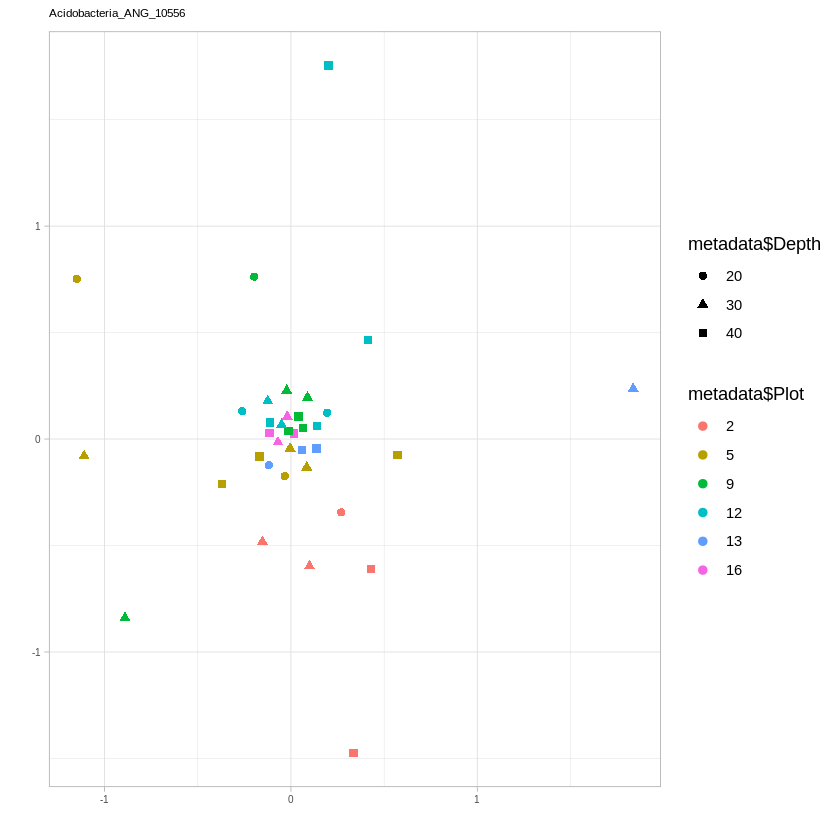

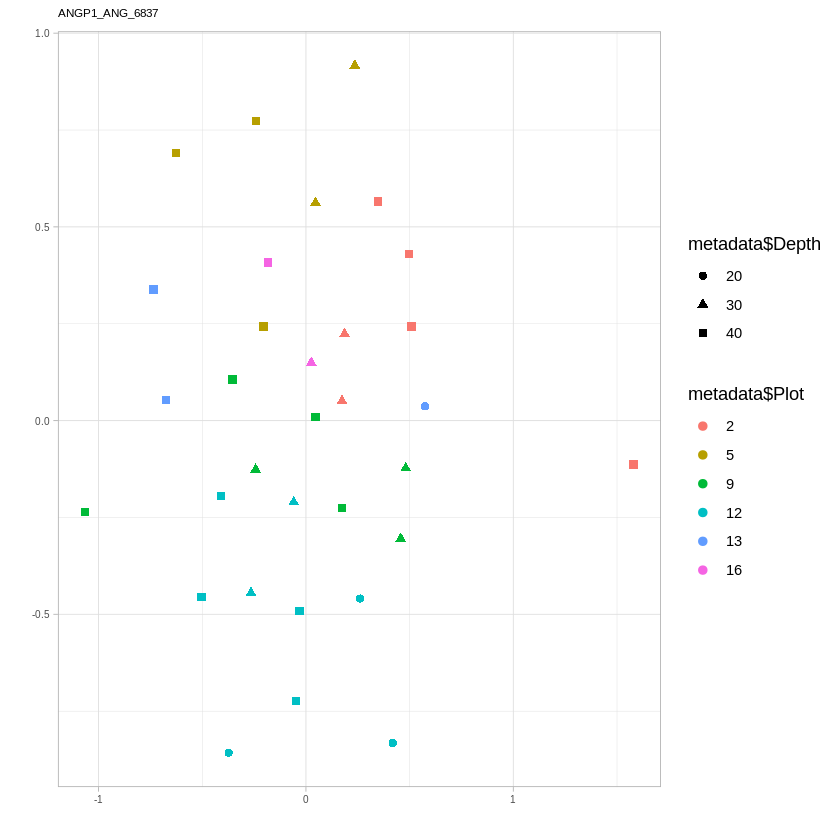

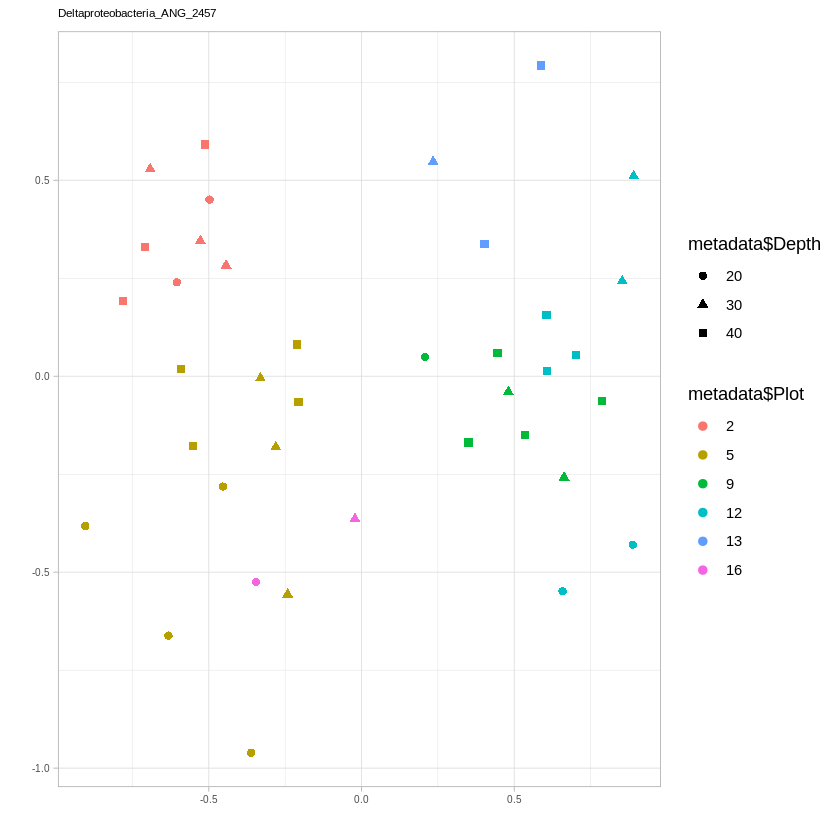

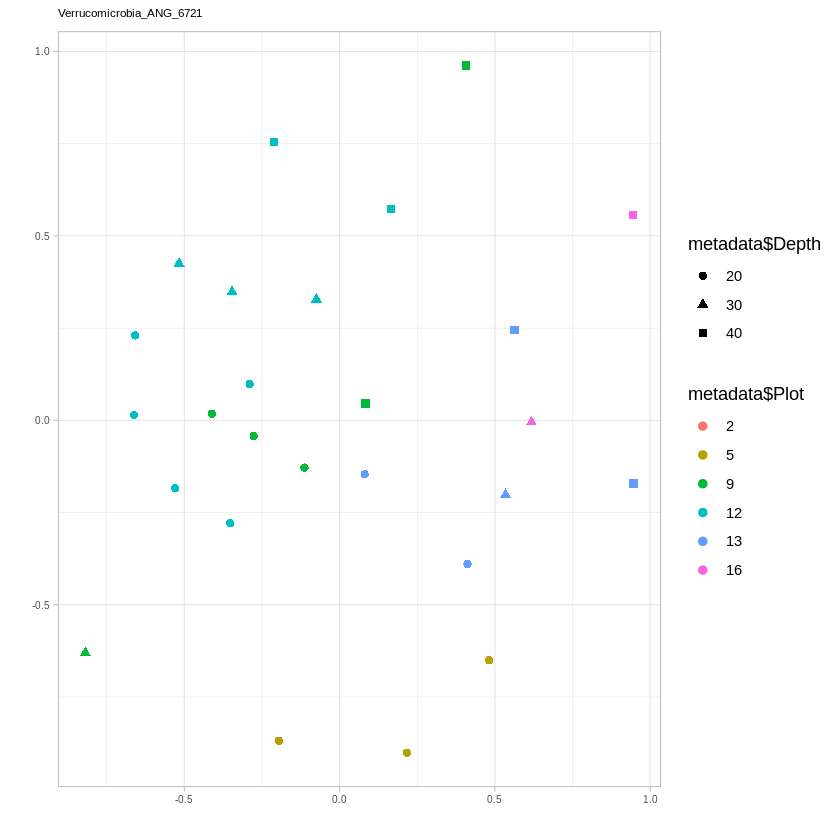

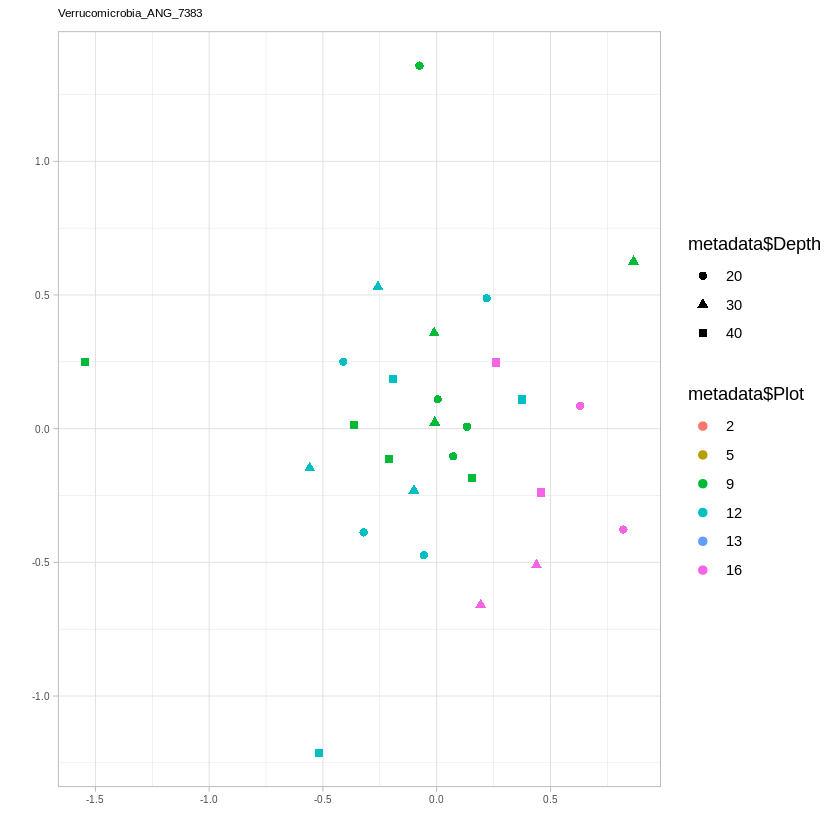

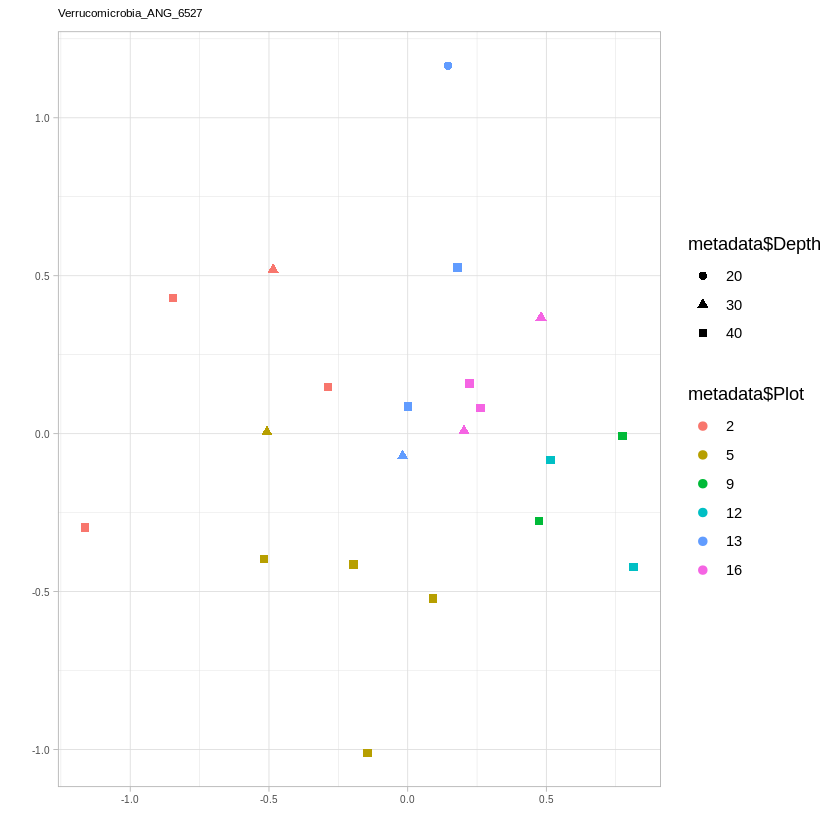

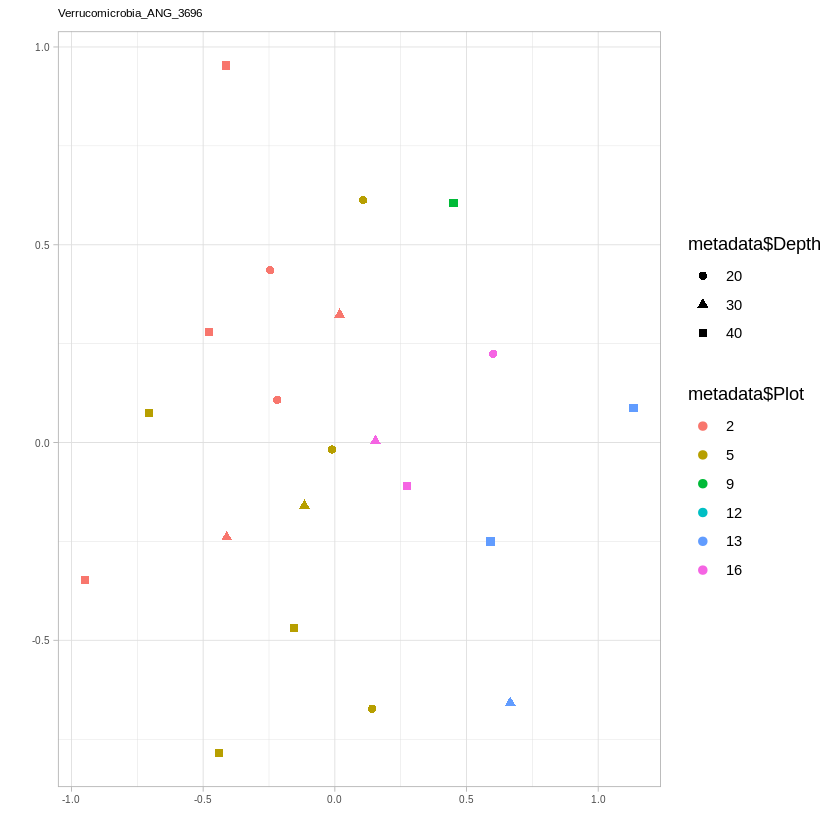

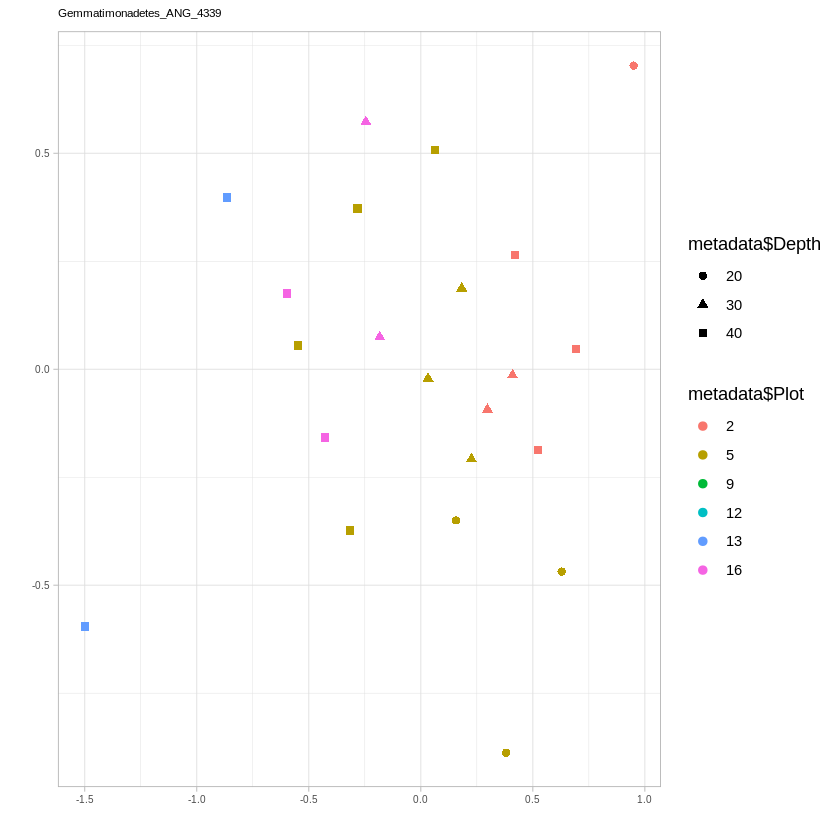

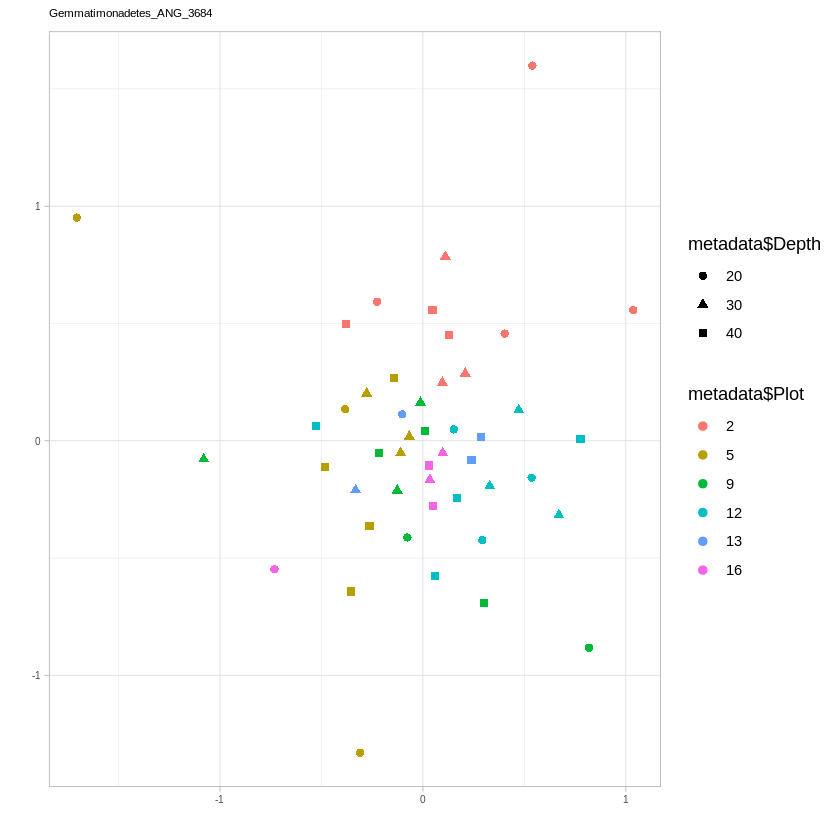

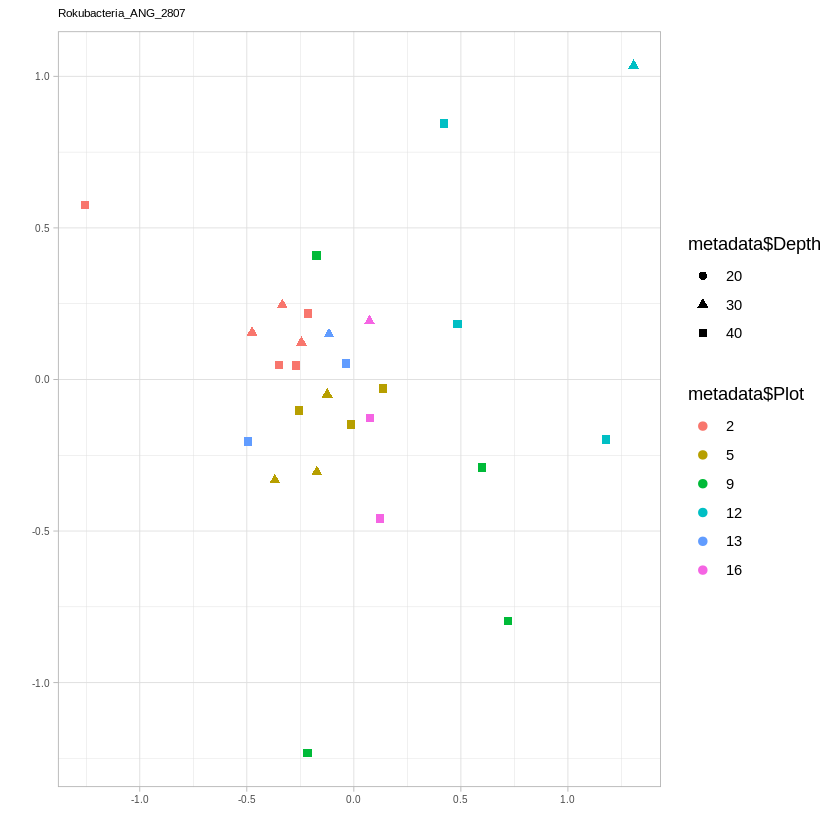

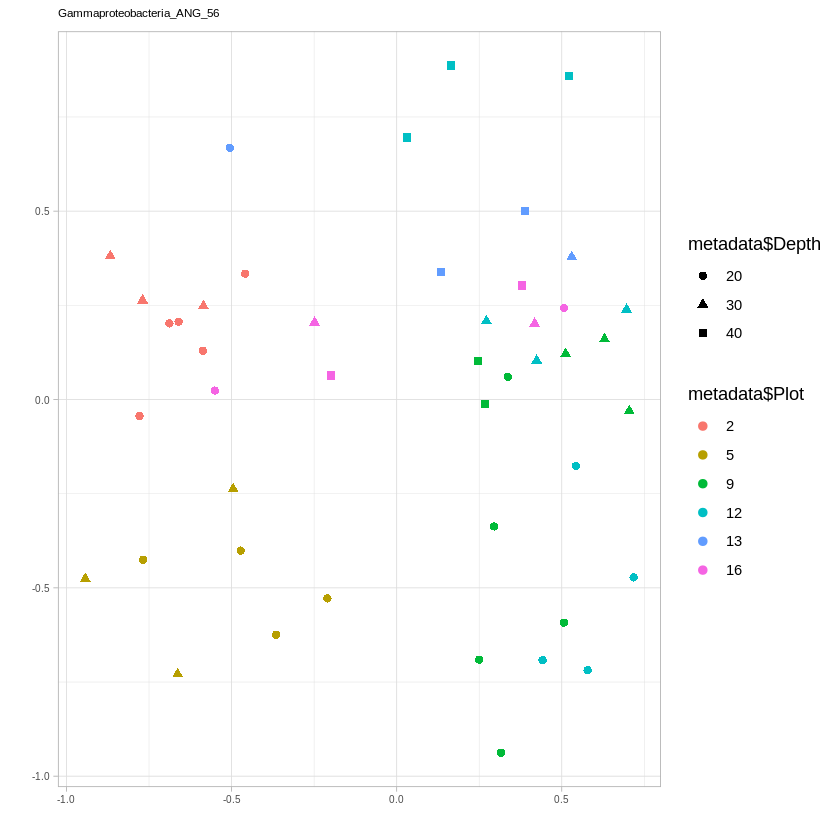

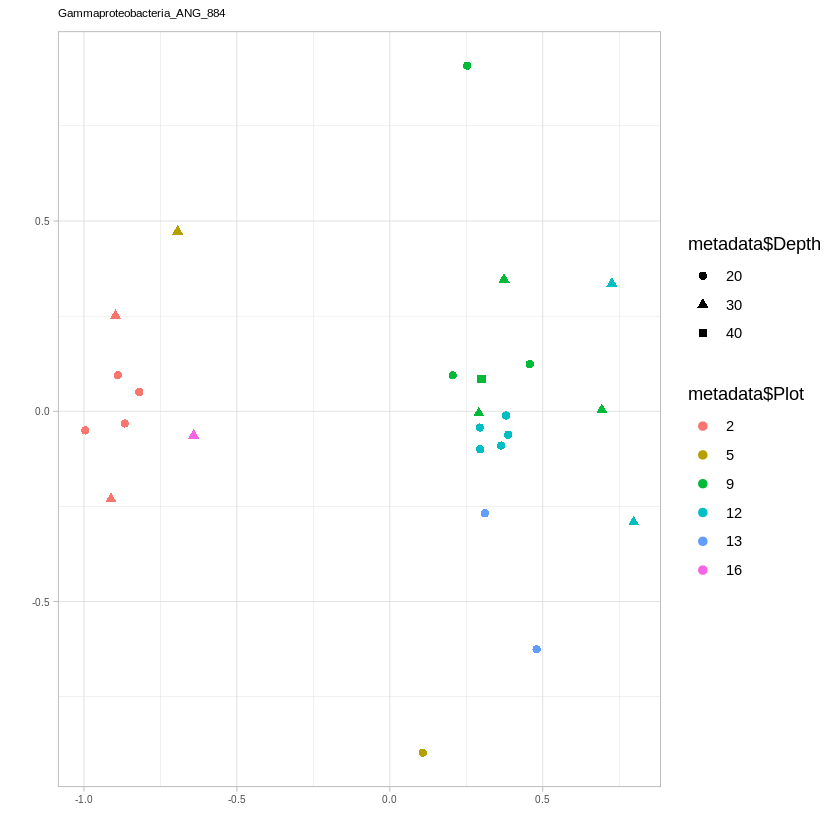

In [44]:
### Create Fig 2B plot
sig_plot = results[which(p.adjust(results$p_plot, method = 'BH') < 0.05),]$genome
names = read.csv('/data6/Angelo/alexcc/AngeloStrainsPaper/names.txt', sep='\t')

i = 0 

d$Plot = as.factor(d$Plot)
d$Depth = as.factor(d$Depth)
for (genome in sig_plot){
    clust = d[which(d$genome == genome),]
    cluster2 = d[which(d$secondary_cluster == clust$secondary_cluster[1]),]$genome
    ani_data = n[which(n$reference %in% cluster2 & n$query %in% cluster2),]
    ani_matrix = dcast(ani_data, reference ~ query, value.var = "ani")
    rownames(ani_matrix) = ani_matrix$reference
    ani_matrix$reference = NULL
    dist_mat = as.dist(1-ani_matrix)
    metadata = d[which(d$genome %in% names(ani_matrix)),]
    mds_result = mds(dist_mat)

#     pdf(file = paste0(names[which(names$old == genome),]$new, '_mds.pdf'), width=4,height=2.666)
    p <- ggplot(as.data.frame(mds_result$conf), aes(x=D1, y=D2, color=metadata$Plot, shape=metadata$Depth))
    p <- p + geom_point(stat = 'identity', size=2) + scale_color_discrete(drop=FALSE) + scale_shape_discrete(drop=FALSE)+
    theme_light() + theme(plot.title = element_text(size=7), axis.text=element_text(size=6)) + xlab("") + ylab("") + 
    labs(title=names[which(names$old == genome),]$new)
    print(p)
#     dev.off()
}

In [45]:
## Create Fig 2A plot

final = merge(names, results, by.x = 'old', by.y='genome')
m_res = melt(final[,c('new', 'r_plot', 'r_depth')])
head(m_res)

Using new as id variables


new,variable,value
<fct>,<fct>,<dbl>
Gammaproteobacteria_ANG_56,r_plot,0.18459480
Acidobacteria_ANG_477,r_plot,0.04381984
ANG-CHLX_750,r_plot,0.07194911
Gammaproteobacteria_ANG_884,r_plot,0.38456351
Chloroflexi_ANG_2135,r_plot,0.03693685
Gemmatimonadetes_ANG_2150,r_plot,0.07242799


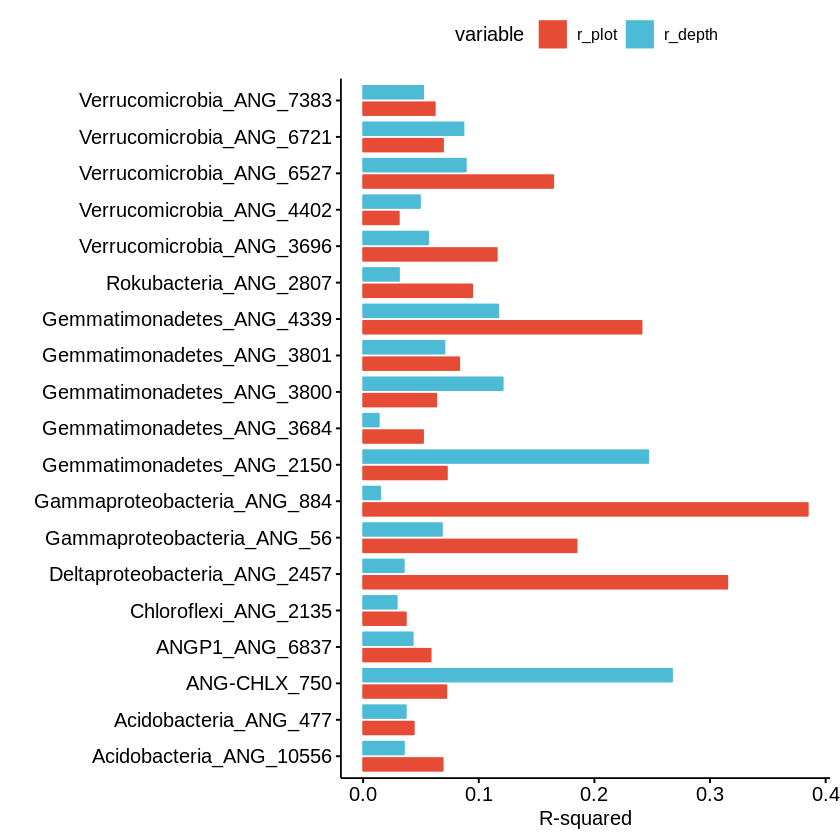

In [46]:
# pdf(file='associations.pdf')
ggbarplot(m_res, x = "new", y = "value",
          fill = "variable", color = "variable", 
          position = position_dodge(0.9), palette = "npg")+coord_flip() + xlab("") + ylab("R-squared")
# dev.off()